In [18]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator, CoxPHSurvivalAnalysis
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt
from utility.risk import InputFunction
from tools.model_trainer import Trainer
from tools.model_builder import make_cox_model

DATASET_NAME = "WHAS500"

# Load data
dl = get_data_loader(DATASET_NAME).load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train, valid and test set
X_columns = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Make event times
lower, upper = np.percentile(y['time'], [10, 90])
event_times = np.arange(lower, upper+1)

# Create Cox model
cox_config = load_config(pt.COX_CONFIGS_DIR, f"{DATASET_NAME.lower()}.yaml")
model = make_cox_model(cox_config)
model.fit(X_train, y_train)

# Select only test samples where event occurs
test_idx = list(np.where(y_test['event'] == True)[0])
X_test = X_test[test_idx]
y_test = y_test[test_idx]

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [19]:
# Compute surv func
test_sample = X_test
test_surv_fn = model.predict_survival_function(test_sample)
surv_preds = np.row_stack([fn(event_times) for fn in test_surv_fn])
surv_preds

array([[0.9156167 , 0.91303064, 0.91303064, ..., 0.39149048, 0.39149048,
        0.39149048],
       [0.8765507 , 0.87285305, 0.87285305, ..., 0.24619448, 0.24619448,
        0.24619448],
       [0.52525595, 0.51451677, 0.51451677, ..., 0.00106019, 0.00106019,
        0.00106019],
       ...,
       [0.66895698, 0.66038373, 0.66038373, ..., 0.01388785, 0.01388785,
        0.01388785],
       [0.69063255, 0.68247939, 0.68247939, ..., 0.01949644, 0.01949644,
        0.01949644],
       [0.83761692, 0.83286858, 0.83286858, ..., 0.15183752, 0.15183752,
        0.15183752]])

In [20]:
# Plot surv funcs
'''
styles = ('-', '--')
plt.figure(dpi=80)
for i, surv_fn in enumerate(test_surv_fn):
    plt.step(event_times, surv_fn(event_times), where="post", label=str(i))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.grid(True)
plt.show()
'''

'\nstyles = (\'-\', \'--\')\nplt.figure(dpi=80)\nfor i, surv_fn in enumerate(test_surv_fn):\n    plt.step(event_times, surv_fn(event_times), where="post", label=str(i))\nplt.legend(loc=\'upper center\', bbox_to_anchor=(0.5, 1.05),\n          ncol=5, fancybox=True, shadow=True)\nplt.ylabel("Probability of survival $S(t)$")\nplt.xlabel("Time $t$")\nplt.grid(True)\nplt.show()\n'

In [21]:
from scipy.integrate import trapezoid
def compute_survival_times(risk_scores, t_train, e_train, seed):
    # https://pubmed.ncbi.nlm.nih.gov/15724232/
    rnd = np.random.RandomState(seed)

    # generate survival time
    mean_survival_time = t_train[e_train].mean()
    baseline_hazard = 1. / mean_survival_time
    scale = baseline_hazard * np.exp(risk_scores)
    u = rnd.uniform(low=0, high=1, size=risk_scores.shape[0])
    t = -np.log(u) / scale

    return t

def trapz_wrapper(X):
    """Helper function
    TBC
    """
    # NOTE: y - values | x - index
    return trapezoid(X.y, X.x)

trapz_times = np.array(list(map(trapz_wrapper, test_surv_fn)))

In [22]:
risk_scores = model.predict(test_sample)
samples = list()
for i in range(0, 500): # sample 500 times
    samples.append(compute_survival_times(risk_scores, t_train, e_train, i))
simulated_times = np.mean(samples, axis=0)
simulated_times

array([238.41711476, 153.04041752,  32.96648886, 284.89721712,
        85.41977806,  21.9035513 , 136.03457426, 273.92421605,
       368.65101611, 354.5570702 ,  38.30224353, 111.30529078,
       111.99840949,  56.52122827,  51.80894034, 148.89601202,
       118.38504687, 443.98000235, 134.13620635, 147.40673106,
       338.65724809,  22.68808327, 356.36593301, 324.75585645,
       133.14023987,  23.4978181 ,  89.43386484,  42.79312409,
        26.14506519,  13.22913125, 105.00558298,  62.36709323,
       765.37849032, 111.620946  , 182.89331308, 287.9459881 ,
       208.5102676 , 980.74164534, 440.20686817, 179.14420552,
        15.96399342, 189.79489437, 324.06975143, 148.91230687,
       474.77534074, 246.73880664,  93.49572894, 151.57304419,
       111.65495428,  49.06619516,  58.21955872, 116.73664979])

In [23]:
from typing import Union
import pandas as pd

def qth_survival_time(q: float, model_or_survival_function) -> float:
    """
    Returns the time when a single survival function reaches the qth percentile, that is,
    solves  :math:`q = S(t)` for :math:`t`.

    Parameters
    ----------
    q: float
      value between 0 and 1.
    model_or_survival_function: Series, single-column DataFrame, or lifelines model


    See Also
    --------
    qth_survival_times, median_survival_times
    """
    from lifelines.fitters import UnivariateFitter

    if isinstance(model_or_survival_function, UnivariateFitter):
        return model_or_survival_function.percentile(q)
    elif isinstance(model_or_survival_function, pd.DataFrame):
        if model_or_survival_function.shape[1] > 1:
            raise ValueError(
                "Expecting a DataFrame (or Series) with a single column. Provide that or use utils.qth_survival_times."
            )
        return qth_survival_time(q, model_or_survival_function.T.squeeze())
    elif isinstance(model_or_survival_function, pd.Series):
        if model_or_survival_function.iloc[-1] > q:
            return np.inf
        return model_or_survival_function.index[(-model_or_survival_function).searchsorted([-q])[0]]
    else:
        raise ValueError(
            "Unable to compute median of object %s - should be a DataFrame, Series or lifelines univariate model"
            % model_or_survival_function
        )

def _to_1d_array(x) -> np.ndarray:
    v = np.atleast_1d(x)
    try:
        if v.shape[0] > 1 and v.shape[1] > 1:
            raise ValueError("Wrong shape (2d) given to _to_1d_array")
    except IndexError:
        pass
    return v

def qth_survival_times(q, survival_functions) -> Union[pd.DataFrame, float]:
    """
    Find the times when one or more survival functions reach the qth percentile.

    Parameters
    ----------
    q: float or array
      a float between 0 and 1 that represents the time when the survival function hits the qth percentile.
    survival_functions: a (n,d) DataFrame, Series, or NumPy array.
      If DataFrame or Series, will return index values (actual times)
      If NumPy array, will return indices.

    Returns
    -------
    float, or DataFrame
         if d==1, returns a float, np.inf if infinity.
         if d > 1, an DataFrame containing the first times the value was crossed.

    See Also
    --------
    qth_survival_time, median_survival_times
    """
    # pylint: disable=cell-var-from-loop,misplaced-comparison-constant,no-else-return
    q = _to_1d_array(q)
    q = pd.Series(q.reshape(q.size), dtype=float)

    if not ((q <= 1).all() and (0 <= q).all()):
        raise ValueError("q must be between 0 and 1")

    survival_functions = pd.DataFrame(survival_functions)

    if survival_functions.shape[1] == 1 and q.shape == (1,):
        q = q[0]
        # If you add print statements to `qth_survival_time`, you'll see it's called
        # once too many times. This is expected Pandas behavior
        # https://stackoverflow.com/questions/21635915/why-does-pandas-apply-calculate-twice
        return survival_functions.apply(lambda s: qth_survival_time(q, s)).iloc[0]
    else:
        d = {_q: survival_functions.apply(lambda s: qth_survival_time(_q, s)) for _q in q}
        survival_times = pd.DataFrame(d).T
        #  Typically, one would expect that the output should equal the "height" of q.
        #  An issue can arise if the Series q contains duplicate values. We solve
        #  this by duplicating the entire row.
        if q.duplicated().any():
            survival_times = survival_times.loc[q]

        return survival_times

In [24]:
#test_surv_fn = model.predict_survival_function(test_sample)
#surv_preds = np.row_stack([fn(event_times) for fn in test_surv_fn])

In [25]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.0001)
data = pd.concat([pd.DataFrame(X_train),
                  pd.Series(y_train['time'], name="Survival_time"),
                  pd.Series(y_train['event'], name="Event")], axis=1)
cph.fit(data, duration_col="Survival_time", event_col="Event")

iteritems is deprecated and will be removed in a future version. Use .items instead.
In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


<lifelines.CoxPHFitter: fitted with 350 total observations, 187 right-censored observations>

In [26]:
lifelines_trapz_times = cph.predict_expectation(test_sample)

In [27]:
lifelines_median_times = cph.predict_median(test_sample)

In [28]:
lifelines_percentile_times = cph.predict_percentile(test_sample, 0.5)

In [16]:
surv_times = cph.predict_survival_function(test_sample)
surv_times[surv_times < 0.05]

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2175.0,NaN,NaN,2.013782e-04,NaN,4.929633e-02,3.808686e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.977845e-03,7.531757e-03,NaN
2178.0,NaN,NaN,2.013782e-04,NaN,4.929633e-02,3.808686e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.977845e-03,7.531757e-03,NaN
2190.0,NaN,NaN,2.013782e-04,NaN,4.929633e-02,3.808686e-06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.977845e-03,7.531757e-03,NaN
2353.0,NaN,0.013275,5.491163e-10,NaN,5.306808e-04,2.642868e-14,8.027085e-03,NaN,NaN,NaN,...,NaN,7.787812e-03,NaN,NaN,6.180133e-04,0.009208,2.679382e-03,1.697904e-06,4.792272e-06,2.088988e-03


In [30]:
real_times = y_test['time']

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

max_time = np.max(y['time'])
res = pd.DataFrame([real_times, trapz_times, simulated_times, lifelines_trapz_times,
                    lifelines_median_times,lifelines_percentile_times]).T
res.columns = ['Real', 'Trapz', 'Sim', 'LL-Trapz', 'LL-Med', 'LL-Per']
res['LL-Med'].replace([np.inf, -np.inf], max_time, inplace=True)
res['LL-Per'].replace([np.inf, -np.inf], max_time, inplace=True)

In [53]:
res[:50]

,Real,Trapz,Sim,LL-Trapz,LL-Med,LL-Per
0,34.0,97.125296,210.738586,97.153013,107.0,40.0
1,82.0,92.729642,130.593975,92.728257,107.0,29.0
2,80.0,90.237820,113.384613,90.207163,107.0,25.0
3,51.0,99.901358,316.866846,99.914182,107.0,49.0
4,44.0,77.123555,50.409658,77.091665,97.0,17.0
5,81.0,97.172707,201.767255,97.176998,107.0,40.0
6,5.0,101.776198,444.154521,101.790043,107.0,66.0
7,29.0,57.592509,26.137869,57.489799,52.0,10.0
8,14.0,89.799790,109.967492,89.753618,107.0,25.0
9,93.0,82.281630,69.306807,82.251844,107.0,20.0


In [32]:
print("MSE")
print(mean_squared_error(res['Real'], res['Trapz']))
print(mean_squared_error(res['Real'], res['Sim']))
print(mean_squared_error(res['Real'], res['LL-Trapz']))
print(mean_squared_error(res['Real'], res['LL-Per']))
print(mean_squared_error(res['Real'], [424]*len(X_test)))
print()
print("MAE")
print(mean_absolute_error(res['Real'], res['Trapz']))
print(mean_absolute_error(res['Real'], res['Sim']))
print(mean_absolute_error(res['Real'], res['LL-Trapz']))
print(mean_absolute_error(res['Real'], res['LL-Per']))
print(mean_absolute_error(res['Real'], [424]*len(X_test)))


MSE
658271.0694393527
344755.65041779075
659905.3052449172
955394.4807692308
308583.1346153846

MAE
613.2112194816917
364.749081645368
613.2116511958682
696.3269230769231
430.1730769230769


ICI =  0.1572674134331777
E50 =  0.17135102407449299


divide by zero encountered in log


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 0.1572674134331777,
 0.17135102407449299)

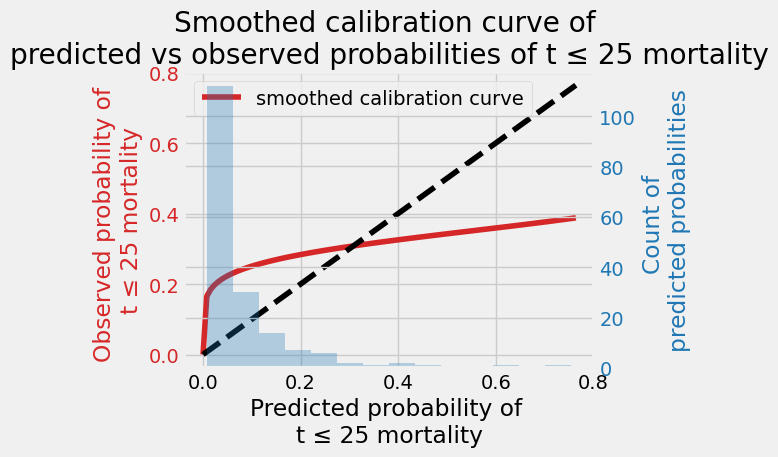

In [55]:
from lifelines.calibration import survival_probability_calibration

data = pd.concat([pd.DataFrame(X_test),
                  pd.Series(y_test['time'], name="Survival_time"),
                  pd.Series(y_test['event'], name="Event")], axis=1)

survival_probability_calibration(cph, data, t0=25)